In [139]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman as RomanLenstronomy
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens

In [140]:
roman = Roman()
lens = SampleStrongLens()
lens._set_classes()

band = 'F129'
arcsec = 5.
oversample = 1
exposure_time = 146

In [141]:
roman_lenstronomy = RomanLenstronomy(band=band)
kwargs_single_band = roman_lenstronomy.kwargs_single_band()
pprint(kwargs_single_band)

{'ccd_gain': 1,
 'exposure_time': 146,
 'magnitude_zero_point': 26.4,
 'num_exposures': 128,
 'pixel_scale': 0.11,
 'psf_type': 'GAUSSIAN',
 'read_noise': 15.5,
 'seeing': 0.105,
 'sky_brightness': 22.99}


In [142]:
kwargs_single_band = {
    'ccd_gain': 1,
    'exposure_time': 1,
    'magnitude_zero_point': zp_mag,
    'num_exposures': 1,
    'pixel_scale': 0.11,
    'psf_type': 'NONE',
    'read_noise': 0,
    # 'seeing': 0.105,
    'sky_brightness': 0
}

In [143]:
sim_api = SimAPI(
        numpix=47,
        kwargs_single_band=kwargs_single_band,
        kwargs_model=lens.kwargs_model,
    )

In [144]:
kwargs_numerics = {
        "point_source_supersampling_factor": 1,
        "supersampling_factor": 1,
    }

image_model = sim_api.image_model_class(kwargs_numerics)

In [145]:
pprint(lens.kwargs_lens)

[{'center_x': -0.007876281728887604,
  'center_y': 0.010633393703246008,
  'e1': 0.004858808997848661,
  'e2': 0.0075210751726143355,
  'theta_E': 1.168082477232392},
 {'dec_0': 0,
  'gamma1': -0.03648819840013156,
  'gamma2': -0.06511863424492038,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': 0.06020941823541971, 'ra_0': 0}]


In [146]:
pprint(lens.kwargs_source_dict[band])

{'R_sersic': 0.1651633078964498,
 'center_x': 0.30298310338567075,
 'center_y': -0.3505004565139597,
 'e1': -0.06350855238708408,
 'e2': -0.08420760408362458,
 'magnitude': 21.121205893763328,
 'n_sersic': 1.0}


In [147]:
kwargs_source_amp_dict = {}

zp_mag = roman.zp_dict['SCA01'][band]

kwargs_source_amp = data_util.magnitude2amplitude(lens.source_model_class, [lens.kwargs_source_dict[band]], zp_mag)
pprint(kwargs_source_amp)

kwargs_lens_light_amp = data_util.magnitude2amplitude(lens.lens_light_model_class, [lens.kwargs_lens_light_dict[band]], zp_mag)
pprint(kwargs_lens_light_amp)

[{'R_sersic': 0.1651633078964498,
  'amp': 367.19169824710224,
  'center_x': 0.30298310338567075,
  'center_y': -0.3505004565139597,
  'e1': -0.06350855238708408,
  'e2': -0.08420760408362458,
  'n_sersic': 1.0}]
[{'R_sersic': 0.5300707454127908,
  'amp': 653.1736698551683,
  'center_x': -0.007876281728887604,
  'center_y': 0.010633393703246008,
  'e1': 0.023377277902774978,
  'e2': 0.05349948216860632,
  'n_sersic': 4.0}]


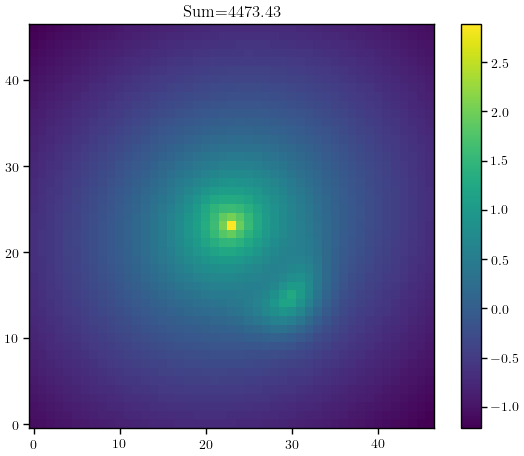

In [151]:
array = image_model.image(
        kwargs_lens=lens.kwargs_lens,
        kwargs_source=kwargs_source_amp,
        kwargs_lens_light=kwargs_lens_light_amp,
        kwargs_ps=None,
        unconvolved=True,
        source_add=True,
        lens_light_add=True,
    )

plt.imshow(np.log10(array))
plt.colorbar()
plt.title(f'Sum={np.sum(array):.2f}')
plt.show()

In [152]:
util.percent_difference(4826.4, 4473.43)

7.59089144640277

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
